In this notebook we are going to walk through the kickstarter dataset from top to bottom to get more repetitions with working through a dataset from top to bottom.

In [1]:
# imports
import pandas as pd
import numpy as np
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
# suppress warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# upload data
df = pd.read_csv(r"https://raw.githubusercontent.com/JonathanBechtel/dat-02-22/main/ClassMaterial/Unit3/data/ks2.csv")

In [3]:
# helper functions to aid in the process
def split_data(df, split_frac=0.2, random_state=42):
    df = df.drop(['deadline', 'launched'], axis = 1)
    X  = df.drop('state', axis=1)
    y  = df['state']
    # notice the use of 'stratify' -- makes sure y values are in equal proportions in train + test
    return train_test_split(X, y, test_size = split_frac, stratify = y, random_state = random_state)

# helper function to pull out feature importances_
def get_feature_importances(pipe, X_train, onehot=False):
    if onehot:
        X_train = pipe[0].transform(X_train)
        X_train = pipe[1].transform(X_train)
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': pipe[-1].feature_importances_
    }).sort_values(by='Importance', ascending=False)

In [4]:
# a variation of what we did previously -- gives us option of getting training / validation / test scores
# in a single function
def get_model_scores(mod, X_train, y_train, X_test, y_test, val_score = True, test_score=False):
    if val_score:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                          test_size = 0.2, 
                                                          stratify = y_train, 
                                                          random_state= 42)
 
    mod.fit(X_train, y_train)
    
    results = {}
    
    results['train_score'] = mod.score(X_train, y_train)
    if val_score:
        results['val_score'] = mod.score(X_val, y_val)
        
    if test_score:
        results['test_score'] = mod.score(X_test, y_test)
        
    return results

In [5]:
# helper function to pull out feature importances_
def get_feature_importances(pipe, X_train, onehot=False):
    if onehot:
        # this section is based on the assumption that we are using a OneHotEncoder + An additional one for name
        X_train = pipe[0].transform(X_train)
        X_train = pipe[1].transform(X_train)
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': pipe[-1].feature_importances_
    }).sort_values(by='Importance', ascending=False)

### Encoding Data

In [6]:
# split data
X_train, X_test, y_train, y_test = split_data(df)

# create pipe and get model score
te   = ce.TargetEncoder(min_samples_leaf = 30)
# setting eval_metric here to avoid a warning message -- does not really change anything though
mod  = XGBClassifier(eval_metric = 'logloss')

pipe = make_pipeline(te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, test_score = True)

# initial scores are closely aligned, will leave test set alone for now
scores

{'train_score': 0.6991522206756928,
 'val_score': 0.6874799655829804,
 'test_score': 0.6884776828494689}

In [7]:
# and initial feature importances
feats = get_feature_importances(pipe, X_train)
feats

,Col,Importance
2,category,0.523398
6,goal,0.205392
5,country,0.103629
3,main_category,0.072589
4,currency,0.060460
0,ID,0.034531
1,name,0.000000


### Your Turn:

Take 3-5 minutes and test the other encoding methods to see which one gives the best results.

**Hint:** You cannot onehot encode every categorical column in this dataset so adjust your pipeline appropriately.

In [8]:
# use an ordinal encoder
ore   = ce.OrdinalEncoder()

pipe = make_pipeline(ore, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)

# initial scores are closely aligned, will leave test set alone for now
scores

{'train_score': 0.7016027668817748, 'val_score': 0.6679769878359455}

In [9]:
# and feature importances
feats = get_feature_importances(pipe, X_train)
feats

,Col,Importance
3,main_category,0.268593
6,goal,0.259358
2,category,0.204294
5,country,0.108002
4,currency,0.094888
1,name,0.032697
0,ID,0.032168


In [10]:
# onehot encoder + target encoder
ohe = ce.OneHotEncoder(cols = ['category', 'country', 'currency'], use_cat_names = True)
te  = ce.TargetEncoder()

pipe = make_pipeline(ohe, te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)

# initial scores are closely aligned, will leave test set alone for now
scores

{'train_score': 0.6977772154034333, 'val_score': 0.6883572621598367}

In [11]:
# and feature importances
feats = get_feature_importances(pipe, X_train, onehot=True)
feats

,Col,Importance
58,category_Hip-Hop,0.064007
161,main_category,0.050888
28,category_Tabletop Games,0.041593
8,category_Shorts,0.034393
176,country_US,0.029721
...,...,...
77,category_Cookbooks,0.000000
61,category_Gaming Hardware,0.000000
175,currency_JPY,0.000000
47,category_Rock,0.000000


### Features!

We have date columns, which are choice targets for extracting out more information.

### Your Turn:

Take 5 - 10 minutes to try and create at least 3 - 5 additional features w/in your data.  

In [12]:
# time based encoding
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

# let 'er rip
df['deadline_days'] = df['deadline'].dt.day
df['deadline_mo']   = df['deadline'].dt.month
df['deadline_year'] = df['deadline'].dt.year
df['time']          = (df['deadline'] - df['deadline'].max()).dt.days
df['duration']      = (df['deadline'] - df['launched'].max()).dt.days
df['deadline_dow']  = df['deadline'].dt.dayofweek
df['deadline_week'] = df['deadline'].dt.week

# let 'er rip
df['launched_days'] = df['launched'].dt.day
df['launched_mo']   = df['launched'].dt.month
df['launched_year'] = df['launched'].dt.year
df['launched_dow']  = df['launched'].dt.dayofweek
df['launched_week'] = df['launched'].dt.week

In [13]:
# re split and score
X_train, X_test, y_train, y_test = split_data(df)

# very modest difference -- will keep for now, even though it seems to have a small difference
scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)
scores

{'train_score': 0.716331350963769, 'val_score': 0.6994584380746715}

In [14]:
# look at feature importances
feats = get_feature_importances(pipe, X_train, onehot=True)
feats

,Col,Importance
58,category_Hip-Hop,0.067006
161,main_category,0.053235
28,category_Tabletop Games,0.042709
8,category_Shorts,0.028079
14,category_Apps,0.026539
...,...,...
173,currency_HKD,0.000000
57,category_Journalism,0.000000
175,currency_JPY,0.000000
50,category_Punk,0.000000


In [15]:
# category averages
train_idx = X_train.index

# averages by category
# do you know why we're only grabbing the indices in the training set?
cat_avgs      = df.iloc[train_idx].groupby('category')['goal'].mean().to_frame().rename({'goal': 'cat_avg'}, axis = 1)
df            = df.merge(cat_avgs, left_on = 'category', right_index = True )
df['cat_avg'] = df['goal'] / df['cat_avg']

# and now our new data
df.head()

,ID,name,category,main_category,currency,deadline,launched,state,country,goal,...,time,duration,deadline_dow,deadline_week,launched_days,launched_mo,launched_year,launched_dow,launched_week,cat_avg
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,0,GB,1533.95,...,-869,-817,4,41,11,8,2015,1,33,0.286323
232,1001028167,Steel Cathedrals- Short poems for the digital ...,Poetry,Publishing,GBP,2013-07-28,2013-06-28 23:17:04,0,GB,6060.97,...,-1672,-1620,6,30,28,6,2013,4,26,1.131324
318,1001468086,Bass River Press,Poetry,Publishing,USD,2015-04-05,2015-03-06 19:58:58,0,US,2000.00,...,-1056,-1004,6,14,6,3,2015,4,10,0.373315
414,1001991458,Poems For Apostates & tales of a young Sciento...,Poetry,Publishing,USD,2014-05-31,2014-05-01 17:47:49,0,US,10000.00,...,-1365,-1313,5,22,1,5,2014,3,18,1.866573
517,1002519316,"Your poem, by me.",Poetry,Publishing,CAD,2015-10-31,2015-10-01 20:00:32,0,CA,757.52,...,-847,-795,5,44,1,10,2015,3,40,0.141397


### Your Turn:

Take 5 - 10 minutes and try and create at least one more column like this, and see if they add anything to your final model.

In [16]:
# averages by category / country
country_avgs      = df.iloc[train_idx].groupby(['country', 'category'])['goal'].mean().to_frame().rename({'goal': 'country_avg'}, axis = 1)
df                = df.merge(country_avgs, left_on = ['country', 'category'], right_index = True)
df['country_avg'] = df['goal'] / df['country_avg']

# re - split & score
X_train, X_test, y_train, y_test = split_data(df)
scores                           = get_model_scores(pipe, X_train, y_train, X_test, y_test)

# and scores
scores

{'train_score': 0.7189349736527906, 'val_score': 0.699022900248072}

So far it seems that the additional info that we've created does not add a lot of additional predictive value.  However, before ditching it, we'll keep all of it during parameter tuning.  The idea is that it's possible certain types of interactions and features might be picked up during later boosting rounds that we cannot see now.

We'll look at parameter tuning using the way we've always done it, as well as a more convenient wrapper called `GridSearch`, which we'll use in the next cell.

In [17]:
# parameter search
estimators = [100, 200, 300, 400]
max_depth  = [3, 4]
sub_sample = [0.8, 0.6] # this is the amount of samples to randomly sample in each round
cv_scores  = []

# do a training loop
for estimator in estimators:
    for depth in max_depth:
        for sample in sub_sample:
            print(f"Fitting new training loop for rounds: {estimator}, depth: {depth}, sampling rate: {sample}")
            pipe[-1].set_params(n_estimators = estimator, max_depth = depth, subsample = sample)
            scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)
            cv_scores.append((scores['train_score'], scores['val_score'], estimator, depth, sample))

Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.6
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.8
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.6
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.6
Fitting new training loop for rounds: 200, depth: 4, sampling rate: 0.8
Fitting new training loop for rounds: 200, depth: 4, sampling rate: 0.6
Fitting new training loop for rounds: 300, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 300, depth: 3, sampling rate: 0.6
Fitting new training loop for rounds: 300, depth: 4, sampling rate: 0.8
Fitting new training loop for rounds: 300, depth: 4, sampling rate: 0.6
Fitting new training loop for rounds: 400, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 400, depth: 3, sampling ra

In [18]:
# and we'll now go ahead and find the best parameter values
max(cv_scores, 
    key = lambda x: x[1]) # this is to grab the second item in each tuple

(0.7251536744759036, 0.7007442158732302, 400, 4, 0.8)

A couple of points to note here is that our best performing model is also our most complicated, suggesting that we probably have more parameter space to explore in order to maximize performance.  

It's also true that the spread of values does not seem to be *that* large, so there's a good chance increasing the size of the model will only bring modest improvements.

For now, let's stop and continue on with our test set and PDP

In [19]:
# set the parameters
pipe[-1].set_params(n_estimators = 400, max_depth = 4, subsample = 0.8)

# and finally get our test score
scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, val_score = False, test_score = True)

In [20]:
# scores
scores

{'train_score': 0.7221415938761458, 'test_score': 0.7025151543789068}

We can see we got pretty good alignment between training and test scores, suggesting that our validation technique was sound.

### GridSearch

We'll now go ahead and look at a simplified way or searching parameters.  It fundamentally goes the same thing, but allows you to load in all of the parameters at once without having to go through a complicated loop.  It's known as GridSearch:  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [21]:
# list the parameters we want to load in the xgbclassifier__ notation is because we want to refer to
# items inside of a pipeline
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300, 400],
    'xgbclassifier__max_depth': [3, 4, 5],
    'xgbclassifier__max_features': [0.6, 0.8, 1],
    'xgbclassifier__subsample': [0.6, 0.8, 0.1]
}

# we'll apply this option for faster fitting -- a nice feature of xgboost
pipe[-1].set_params(tree_method = 'hist')

# import a splitter - way to automatically split your data for you
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 3)

grid = GridSearchCV(pipe, param_grid, cv = kfold, verbose = 1)
grid.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [ ]:
# this will give us the best results from the search
grid.best_params_

### Partial Dependence

With our modeling behind us, we'll now go ahead and pull some PDP charts to see what types of patterns were found inside of our final fitted model.  Since `category` and `goal` were two important features, we'll look at those two.

### Your Turn:

Now that we've finished with this, try and create PDP plots to answer the following questions:

 - what is the overall relationship between fundraising amount and your chance of completing a successful campaign?
 - what campaigns give you the highest probability of successfully completing a campaign?  The lowest?
 - if you have any ambitions for running a campaign, how would the intersection of your campaign category and your desired fundraising amount interact?

In [22]:
from pdpbox import pdp, info_plots

# go ahead and transform X_train to prep it for PDPBox
# the model is already fitted so we don't have to worry about doing that
X_train = pipe[0].transform(X_train)
X_train = pipe[1].transform(X_train)

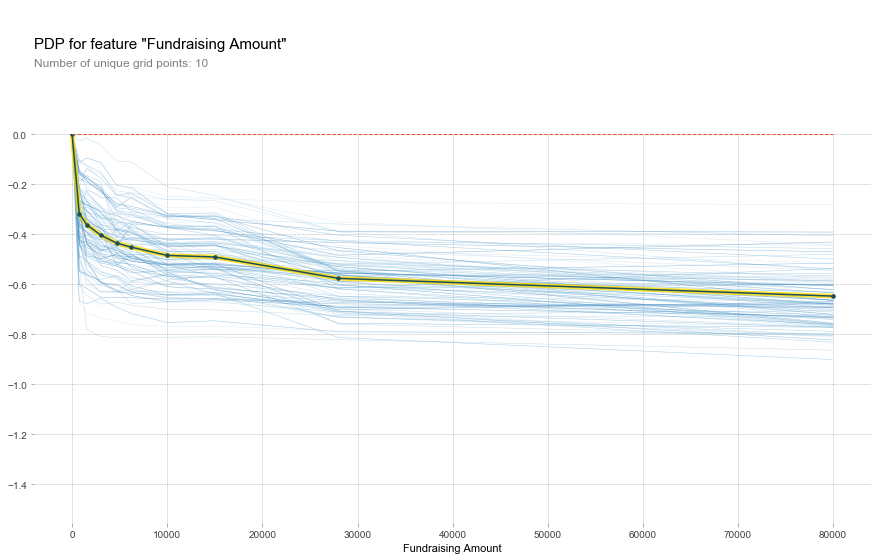

In [23]:
# what was the additive impact of different values of goal?  What was its marginal impact?
pdp_day_of_week = pdp.pdp_isolate(
    model=pipe[-1], 
    dataset=X_train[X_train['goal'] < X_train['goal'].quantile(.95)], # filtering out unusually large values
    model_features=X_train.columns.tolist(), 
    feature='goal',
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Fundraising Amount', plot_lines=True, frac_to_plot=100)

In [24]:
cat_cols = [col for col in X_train.columns if 'category' in col and col != 'main_category']
cat_cols

['category_Shorts',
 'category_Family',
 'category_Digital Art',
 'category_Film & Video',
 'category_Gadgets',
 'category_Live Games',
 'category_Dance',
 'category_Tabletop Games',
 'category_Product Design',
 'category_Graphic Design',
 'category_Comedy',
 'category_Mixed Media',
 'category_Animation',
 'category_Robots',
 'category_Apparel',
 'category_Webseries',
 'category_Indie Rock',
 'category_Publishing',
 'category_Theater',
 'category_Hardware',
 'category_Rock',
 'category_Video Games',
 "category_Children's Books",
 'category_Country & Folk',
 'category_Footwear',
 'category_Nonfiction',
 'category_Sculpture',
 'category_Fiction',
 'category_Food',
 'category_Apps',
 'category_Journalism',
 'category_Music',
 'category_Movie Theaters',
 'category_3D Printing',
 'category_Documentary',
 'category_Small Batch',
 'category_Fashion',
 'category_Software',
 'category_Accessories',
 'category_Painting',
 'category_Fine Art',
 'category_Translations',
 'category_Television',
 'c

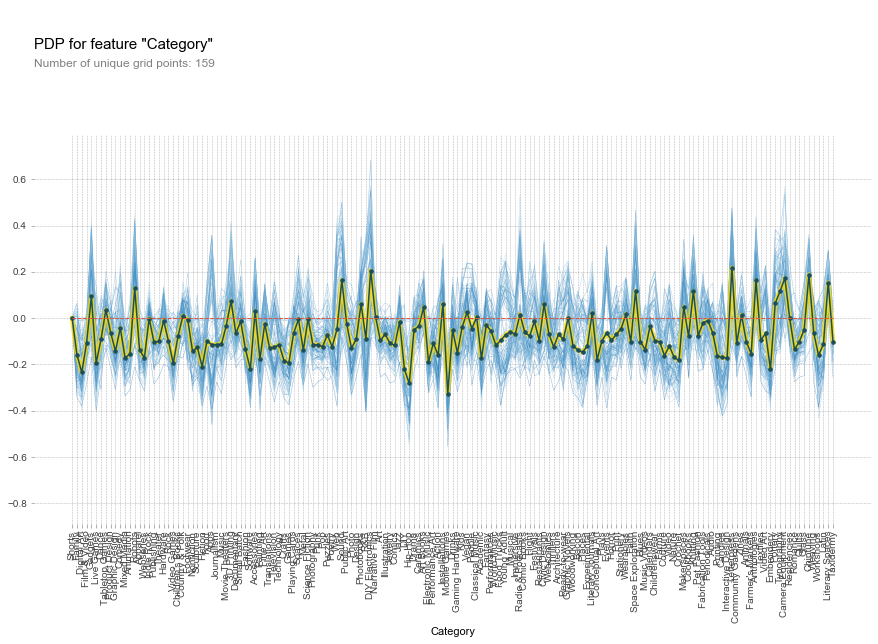

In [25]:
pdp_cat = pdp.pdp_isolate(
    # dataset -- create the final transformation of our data
    model= pipe[-1], dataset=X_train, model_features=X_train.columns.tolist(), 
    # this is the list of all the columns for the genre feature
    feature=cat_cols
)

fig, axes = pdp.pdp_plot(pdp_cat, 'Category', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [cat.split('_')[1] for cat in cat_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

In [26]:
#evaluating the model with a confusion matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

plot_confusion_matrix(pipe, X_val, y_val,
                                 cmap=plt.cm.Blues,
                                 normalize='true');

NameError: name 'X_val' is not defined

In [ ]:
print(classification_report(y_val, pipe.predict(X_val)))